In [2]:
import glob
import matplotlib
import matplotlib.pyplot as plt
import pickle
import lmfit
import numpy as np
import scipy.stats as ss
plt.style.use('seaborn-white')
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.formula.api import ols, rlm
import sys
sys.path.append('../')
from Linearity import Neuron

In [3]:
filename = '/media/sahil/NCBS_Shares_BGStim/patch_data/161013/c1/plots/c1.pkl'

In [4]:
#Colorscheme for squares
color_sqr = { index+1: color for index, color in enumerate(matplotlib.cm.viridis(np.linspace(0,1,9)))}

In [5]:
control_result2_rsquared_adj = []
control_result1_rsquared_adj = []
control_var_expected = []
gabazine_result2_rsquared_adj = []
gabazine_result1_rsquared_adj = []
gabazine_var_expected = []
tolerance = 5e-4

In [25]:
def linearModel(x, a=1):
    # Linear model
    return (a*x)

def DN_model(x,a=1):
    # Divisive normalization model
    #return x - a*(x**2)/(b+x)
    return x/(a*x+1)

def DN_1_model(x,a=1):
    # Divisive normalization model
    #return x - a*(x**2)/(b+x)
    return a*x/(x+1)

def DN_2_model(x,a=1,b=1):
    # Divisive normalization model
    #return x - a*(x**2)/(b+x)
    return x/(a*x+b)

In [26]:
lin_aic = []
dn_aic = []
lin_chi = []
dn_chi = []

control_observed = {}
control_observed_average = {}
gabazine_observed ={}
gabazine_observed_average = {}
control_expected = {}
control_expected_average = {}
gabazine_expected ={}
gabazine_expected_average = {}
feature = 0

neuron = Neuron.load(filename)
for expt in neuron.experiment:
    print ("Starting expt {}".format(expt))
    for numSquares in neuron.experiment[expt].keys(): 
        print ("Square {}".format(numSquares))
        if not numSquares == 1:
            nSquareData = neuron.experiment[expt][numSquares]
            if expt == "Control":
                coords_C = nSquareData.coordwise
                for coord in coords_C: 
                    if feature in coords_C[coord].feature:
                        control_observed_average.update({coord: coords_C[coord].average_feature[feature]})
                        control_expected_average.update({coord: coords_C[coord].expected_feature[feature]})
                        control_observed.update({coord: []})
                        control_expected.update({coord: []})
                        for trial in coords_C[coord].trials:
                            if feature in trial.feature:
                                control_observed[coord].append(trial.feature[feature])
                                control_expected[coord].append(coords_C[coord].expected_feature[feature])
            elif expt == "GABAzine":
                coords_I = nSquareData.coordwise
                for coord in coords_I: 
                    if feature in coords_I[coord].feature:
                        gabazine_observed.update({coord: []})
                        gabazine_expected.update({coord: []})
                        gabazine_observed_average.update({coord: coords_I[coord].average_feature[feature]})
                        gabazine_expected_average.update({coord: coords_I[coord].expected_feature[feature]})

                        for trial in coords_I[coord].trials:
                            if feature in trial.feature:
                                gabazine_observed[coord].append(trial.feature[feature])
                                gabazine_expected[coord].append(coords_I[coord].expected_feature[feature])
print ("Read {} into variables".format(filename))

Starting expt Control
Square 1
Square 2
Square 3
Square 5
Square 7
Square 9
Starting expt GABAzine
Square 1
Square 2
Square 3
Square 5
Square 7
Square 9
Read /media/sahil/NCBS_Shares_BGStim/patch_data/161013/c1/plots/c1.pkl into variables


In [27]:
neuron.features

{0: 'epsp_max',
 1: 'epsp_area',
 2: 'epsp_avg',
 3: 'epsp_time_to_peak',
 4: 'epsp_area_to_peak',
 5: 'epsp_min',
 6: 'epsp_onset'}

In [28]:
feature = 0
expected, observed, g_expected, g_observed = {}, {}, {}, {}
for exp in neuron:
    for sqr in exp:
        ## Control case
        if(exp[sqr].type == "Control"):
            if sqr > 1:
                expected[sqr] = []
                observed[sqr] = []
                for coord in exp[sqr].coordwise:
                    for trial in exp[sqr].coordwise[coord].trials:
                        if all([value == 0 for value in trial.flags.values()]):
                            expected[sqr].append(exp[sqr].coordwise[coord].expected_feature[feature])
                            observed[sqr].append(trial.feature[feature])
        ## Gabazine case
        if(exp[sqr].type == "GABAzine"):
            if sqr > 1:
                g_expected[sqr] = []
                g_observed[sqr] = []
                for coord in exp[sqr].coordwise:
                    for trial in exp[sqr].coordwise[coord].trials:
                        if all([value == 0 for value in trial.flags.values()]):
                            g_expected[sqr].append(exp[sqr].coordwise[coord].expected_feature[feature])
                            g_observed[sqr].append(trial.feature[feature])

[[Model]]
    Model(linearModel)
[[Fit Statistics]]
    # function evals   = 8
    # data points      = 361
    # variables        = 2
    chi-square         = 198.945
    reduced chi-square = 0.554
    Akaike info crit   = -211.102
    Bayesian info crit = -203.325
[[Variables]]
    a:   0.14819421 +/- 0.013968 (9.43%) (init= 1)
    b:   1.08195697 +/- 0.084018 (7.77%) (init= 1)
[[Correlations]] (unreported correlations are <  0.100)
    C(a, b)                      = -0.885 

[[Model]]
    Model(DN_model)
[[Fit Statistics]]
    # function evals   = 25
    # data points      = 361
    # variables        = 2
    chi-square         = 189.572
    reduced chi-square = 0.528
    Akaike info crit   = -228.524
    Bayesian info crit = -220.746
[[Variables]]
    a:   0.32835100 +/- 0.020207 (6.15%) (init= 1)
    b:   0.89209527 +/- 0.108360 (12.15%) (init= 1)
[[Correlations]] (unreported correlations are <  0.100)
    C(a, b)                      = -0.881 

[[Model]]
    Model(linearModel)
[[

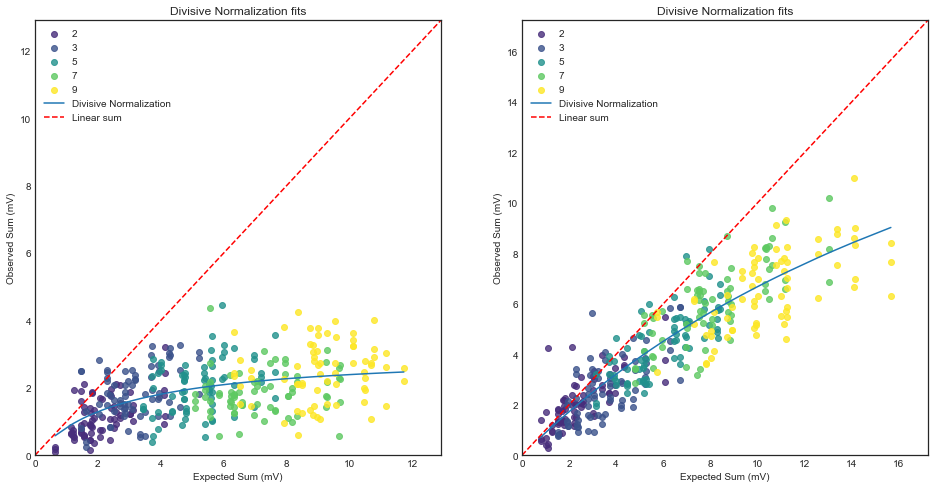

In [29]:
f, ax = plt.subplots(1,2)

## Control stuff
squareVal = []
list_control_expected = []
list_control_observed = []

max_exp, max_g_exp = 0.,0.
for sqr in sorted(observed):
    squareVal.append(ax[0].scatter(expected[sqr], observed[sqr], label=str(sqr), c=color_sqr[sqr], alpha=0.8))
    max_exp = max(max_exp, max(expected[sqr]))
    list_control_expected += expected[sqr]
    list_control_observed += observed[sqr]
    
X = np.array(list_control_expected)
y = np.array(list_control_observed)
idx   = np.argsort(X)
X = X[idx]
y = y[idx]

linear_Model = lmfit.Model(linearModel)
DN_Model = lmfit.Model(DN_model)

lin_pars = linear_Model.make_params()
lin_result = linear_Model.fit(y, lin_pars, x=X)
lin_aic.append(lin_result.aic)
lin_chi.append(lin_result.redchi)

DN_pars = DN_Model.make_params()
DN_result = DN_Model.fit(y, DN_pars, x=X)
dn_aic.append(DN_result.aic)
dn_chi.append(DN_result.redchi)

print (lin_result.fit_report())
print (DN_result.fit_report())

ax[0].set_xlim(xmin=0.)
ax[0].set_ylim(ymin=0.)
ax[0].set_xlabel("Expected")
ax[0].set_ylabel("Observed")
ax[0].set_title("Divisive Normalization fits")
div_norm = ax[0].plot(X, DN_result.best_fit, '-')


max_exp *=1.1
max_g_exp *=1.1
ax[0].set_xlim(0,max_exp)
ax[0].set_ylim(0,max_exp)
ax[0].set_xlabel("Expected Sum (mV)")
ax[0].set_ylabel("Observed Sum (mV)")
linear = ax[0].plot((0,max_exp), (0,max_exp), 'r--')

legends = squareVal + div_norm + linear
labels = sorted(observed.keys()) + [ "Divisive Normalization", "Linear sum"]
ax[0].legend(legends, labels)


### GABAzine stuff 
squareVal = []
list_gabazine_expected = []
list_gabazine_observed = []

max_exp, max_g_exp = 0.,0.
for sqr in sorted(g_observed):
    squareVal.append(ax[1].scatter(g_expected[sqr], g_observed[sqr], label=str(sqr), c=color_sqr[sqr], alpha=0.8))
    max_exp = max(max_exp, max(g_expected[sqr]))
    list_gabazine_expected += g_expected[sqr]
    list_gabazine_observed += g_observed[sqr]
    
X = np.array(list_gabazine_expected)
y = np.array(list_gabazine_observed)
idx   = np.argsort(X)
X = X[idx]
y = y[idx]

linear_Model = lmfit.Model(linearModel)
DN_Model = lmfit.Model(DN_model)

lin_pars = linear_Model.make_params()
lin_result = linear_Model.fit(y, lin_pars, x=X)
lin_aic.append(lin_result.aic)
lin_chi.append(lin_result.redchi)

DN_pars = DN_Model.make_params()
DN_result = DN_Model.fit(y, DN_pars, x=X)
dn_aic.append(DN_result.aic)
dn_chi.append(DN_result.redchi)

print (lin_result.fit_report())
print (DN_result.fit_report())

ax[1].set_xlim(xmin=0.)
ax[1].set_ylim(ymin=0.)
ax[1].set_xlabel("Expected")
ax[1].set_ylabel("Observed")
ax[1].set_title("Divisive Normalization fits")
div_norm = ax[1].plot(X, DN_result.best_fit, '-')


max_exp *=1.1
max_g_exp *=1.1
ax[1].set_xlim(0,max_exp)
ax[1].set_ylim(0,max_exp)
ax[1].set_xlabel("Expected Sum (mV)")
ax[1].set_ylabel("Observed Sum (mV)")
linear = ax[1].plot((0,max_exp), (0,max_exp), 'r--')

legends = squareVal + div_norm + linear
labels = sorted(observed.keys()) + [ "Divisive Normalization", "Linear sum"]
ax[1].legend(legends, labels)

f.set_figwidth(16)
f.set_figheight(8)

plt.show()

## C Gabazine - Control responses

In [52]:
feature = 0
#expected, observed, g_expected, g_observed = {}, {}, {}, {}
control, gabazine = {}, {}
for exp in neuron:
    for sqr in exp:
        ## Control case
        if(exp[sqr].type == "Control"):
            if sqr > 1:
                expected[sqr] = []
                observed[sqr] = []
                for coord in exp[sqr].coordwise:
                    if all([value == 0 for value in exp[sqr].coordwise[coord].flags.values()]):
                        control[sqr] = exp[sqr]
#                         expected[sqr].append(exp[sqr].coordwise[coord].expected_feature[feature])
#                         observed[sqr].append(exp[sqr].coordwise[coord].average_feature[feature])
        ## Gabazine case
        if(exp[sqr].type == "GABAzine"):
            if sqr > 1:
                g_expected[sqr] = []
                g_observed[sqr] = []
                for coord in exp[sqr].coordwise:
                    if all([value == 0 for value in exp[sqr].coordwise[coord].flags.values()]):
                        gabazine[sqr] = exp[sqr]
#                         g_expected[sqr].append(exp[sqr].coordwise[coord].expected_feature[feature])
#                         g_observed[sqr].append(exp[sqr].coordwise[coord].average_feature[feature])

derived_inh, exc = {}, {}
for sq in set(control).intersection(set(gabazine)):
    derived_inh[sq] = []
    exc[sq] = []
    for coord in set(control[sq].coordwise).intersection(set(gabazine[sq].coordwise)):
        derived_inh[sq].append(gabazine[sq].coordwise[coord].average_feature[feature] - control[sq].coordwise[coord].average_feature[feature])
        exc[sq].append(gabazine[sq].coordwise[coord].average_feature[feature])

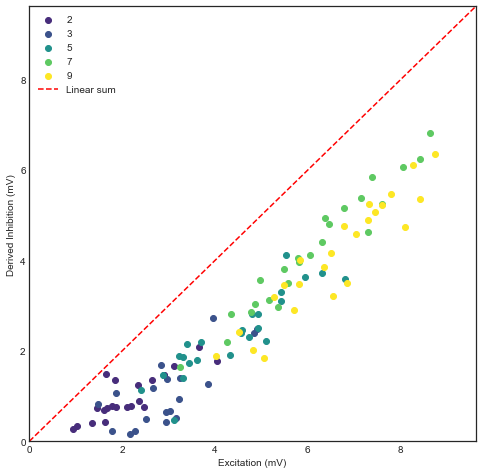

In [53]:
### Derived Inh
squareVal = []
list_exc = []
list_inh = []
f, ax = plt.subplots()
max_exp, max_g_exp = 0.,0.
for sqr in sorted(derived_inh):
    squareVal.append(ax.scatter(exc[sqr], derived_inh[sqr], label=str(sqr), c=color_sqr[sqr]))
    max_exp = max(max_exp, max(exc[sqr]))
    
max_exp *=1.1
max_g_exp *=1.1
ax.set_xlim(0,max_exp)
ax.set_ylim(0,max_exp)
ax.set_xlabel("Excitation (mV)")
ax.set_ylabel("Derived Inhibition (mV)")
linear = ax.plot((0,max_exp), (0,max_exp), 'r--')

legends = squareVal + linear
labels = sorted(observed.keys()) + [ "Linear sum"]
ax.legend(legends, labels)

f.set_figwidth(8)
f.set_figheight(8)

plt.show()

In [ ]:
list_control_observed   = []  
list_gabazine_observed  = []
list_control_expected   = []
list_gabazine_expected  = []

if len(gabazine_observed_average):
    for key in gabazine_observed_average.keys():
        element1, element2 = gabazine_observed_average[key], gabazine_expected_average[key]
        if not (element1 <0 or np.isclose(element1, 0, atol=tolerance) or element2<0 or np.isclose(element2, 0, atol=tolerance)):
            list_gabazine_observed.append(element1)
            list_gabazine_expected.append(element2)

if len(control_observed_average):
    for key in control_observed_average.keys():
        element1, element2 = control_observed_average[key], control_expected_average[key]
        if not (element1 <0 or np.isclose(element1, 0, atol=tolerance) or element2<0 or np.isclose(element2, 0, atol=tolerance)):
            list_control_observed.append(element1)
            list_control_expected.append(element2)

In [15]:
list_control_observed   = []  
list_gabazine_observed  = []
list_control_expected   = []
list_gabazine_expected  = []

if len(gabazine_observed):
    for key in gabazine_observed.keys():
        for element1, element2 in zip(gabazine_observed[key], gabazine_expected[key] ):
            if not (element1 <0 or np.isclose(element1, 0, atol=tolerance) or element2<0 or np.isclose(element2, 0, atol=tolerance)):
                list_gabazine_observed.append(element1)
                list_gabazine_expected.append(element2)

if len(control_observed):
    for key in control_observed.keys():
        for element1, element2 in zip(control_observed[key], control_expected[key] ):
            if not (element1 <0 or np.isclose(element1, 0, atol=tolerance) or element2<0 or np.isclose(element2, 0, atol=tolerance)):
                list_control_observed.append(element1)
                list_control_expected.append(element2)

In [ ]:
minPoints = 10
minIQR = 3
if len(list_control_expected)>minPoints and len(list_control_observed)> minPoints and ss.iqr(list_control_expected)>minIQR:
    print ("Control")
    X = np.array(list_control_expected)
    y = np.array(list_control_observed)
    idx   = np.argsort(X)
    X = X[idx]
    y = y[idx]

    linear_Model = lmfit.Model(linearModel)
    DN_Model = lmfit.Model(DN_model)

    lin_pars = linear_Model.make_params()
    lin_result = linear_Model.fit(y, lin_pars, x=X)
    lin_aic.append(lin_result.aic)
    lin_chi.append(lin_result.redchi)

    DN_pars = DN_Model.make_params()
    DN_result = DN_Model.fit(y, DN_pars, x=X)
    dn_aic.append(DN_result.aic)
    dn_chi.append(DN_result.redchi)

    print (lin_result.fit_report())
    print (DN_result.fit_report())

    ax = plt.subplot(111)
    ax.scatter(X, y, alpha=0.2)
    ax.set_xlim(xmin=0.)
    ax.set_ylim(ymin=0.)
    ax.set_xlabel("Expected")
    ax.set_ylabel("Observed")
    ax.set_title("Divisive Normalization and Inhibition fits")
    ax.plot(X, lin_result.best_fit, '-', label="Divisive Inhibition Model")
    ax.plot(X, DN_result.best_fit, '-', label="Divisive Normalization Model")
    plt.legend()
    plt.show()

In [ ]:
if len(list_gabazine_expected)>minPoints and len(list_gabazine_observed)>minPoints and ss.iqr(list_gabazine_expected)>minIQR :

    print ("GABAzine")
    X = np.array(list_gabazine_expected)
    y = np.array(list_gabazine_observed)
    
    idx   = np.argsort(X)
    X = X[idx]
    y = y[idx]

    linear_Model = lmfit.Model(linearModel)
    DN_Model = lmfit.Model(DN_model)

    lin_pars = linear_Model.make_params()
    lin_result = linear_Model.fit(y, lin_pars, x=X)
    lin_aic.append(lin_result.aic)
    lin_chi.append(lin_result.redchi)

    DN_pars = DN_Model.make_params()
    DN_result = DN_Model.fit(y, DN_pars, x=X)
    dn_aic.append(DN_result.aic)
    dn_chi.append(DN_result.redchi)

    print (lin_result.fit_report())
    print (DN_result.fit_report())

    ax = plt.subplot(111)
    ax.scatter(X, y, alpha=0.2)
    ax.set_xlim(xmin=0.)
    ax.set_ylim(ymin=0.)
    ax.set_xlabel("Expected")
    ax.set_ylabel("Observed")
    ax.set_title("Divisive Normalization and Inhibition fits")
    ax.plot(X, lin_result.best_fit, '-', label="Divisive Inhibition Model")
    ax.plot(X, DN_result.best_fit, '-', label="Divisive Normalization Model")
    plt.legend()
    plt.show()

### GABAzine plotted with control

In [ ]:
list_control_observed   = []  
list_gabazine_observed  = []
list_control_expected   = []
list_gabazine_expected  = []

if len(gabazine_observed_average) and len(control_observed_average):
    for key in list(set(gabazine_observed_average).intersection(set(control_observed_average))):
        element1, element2 =  gabazine_observed_average[key], control_observed_average[key]
        if not (element1 <0 or np.isclose(element1, 0, atol=tolerance) or element2<0 or np.isclose(element2, 0, atol=tolerance)):
            list_gabazine_observed.append(element1)
            list_control_observed.append(element2)

In [ ]:
print ("GABAzine and control")
#X = np.array(list_gabazine_expected)
#y = np.array(list_gabazine_observed)

y = np.array(list_control_observed)
X = np.array(list_gabazine_observed)

idx   = np.argsort(X)
X = X[idx]
y = y[idx]

linear_Model = lmfit.Model(linearModel)
DN_Model = lmfit.Model(DN_model)

lin_pars = linear_Model.make_params()
lin_result = linear_Model.fit(y, lin_pars, x=X)
lin_aic.append(lin_result.aic)
lin_chi.append(lin_result.redchi)

DN_pars = DN_Model.make_params()
DN_result = DN_Model.fit(y, DN_pars, x=X)
dn_aic.append(DN_result.aic)
dn_chi.append(DN_result.redchi)

print (lin_result.fit_report())
print (DN_result.fit_report())

ax = plt.subplot(111)
ax.scatter(X, y, alpha=0.2)
ax.set_xlim(xmin=0.)
ax.set_ylim(ymin=0.)
ax.set_xlabel("Expected")
ax.set_ylabel("Observed")
ax.set_title("Divisive Normalization and Inhibition fits")
ax.plot(X, lin_result.best_fit, '-', label="Divisive Inhibition Model")
ax.plot(X, DN_result.best_fit, '-', label="Divisive Normalization Model")
plt.show()

### For averaged out responses